Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [430]:
import logging
from itertools import combinations
from itertools import permutations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

In [431]:
CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Abakan,53.72,91.43
1,Achinsk,56.28,90.50
2,Almetyevsk,54.90,52.31
3,Angarsk,52.57,103.91
4,Arkhangelsk,64.57,40.53


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [432]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

In [433]:
def valid(res, dists):
    cost = 0
    i = 0
    k = 0
    init = k
    while True:
        i += 1
        cost += dists[k, res[k]]
        k = res[k]
        if(k == init):
            break
    
    return (i == len(CITIES), cost)

## Greedy

In [434]:
import matplotlib.pyplot as plt

nMs = 8
div = nMs


def getDist(a, b, dists, trad):
    if trad is None:
        return dists[a, b]
    else:
        return dists[trad[a], trad[b]]

def _solve(start, end, nodes, dists):
    nodes = set(nodes)
    nodes.discard(start)
    nodes.discard(end)

    min = np.inf
    res = None

    for p in permutations(nodes, len(nodes)):
        p = (start, ) + p + (end, )
        cost = 0
        for k in range(len(p)-1):
            cost = cost + dists[p[k], p[k+1]]
        
        if(cost < min):
            min = cost
            res = p

    return (res, min)

def make_partition(nodes, mains, dists):
    res = [[] for _ in mains]

    for k in range(len(nodes)):
        d = np.array([dists[mains[j], nodes[k]] for j in range(len(mains))])
        min = np.argmin(d)
        res[min] += [nodes[k]]

    return res

def make_subproblem(start, end, mains, partitions, dists):
    probs = []
    cur_start = start
    for m in range(len(mains) - 1):
        nextset = set(partitions[m+1])
        nextset.discard(end)

        d = np.array([dists[mains[m], pn] for pn in nextset])

        if len(d) > 0:
            cur_end = partitions[m+1][np.argmin(d)]
        else:
            cur_end = end

        partitions[m] += [cur_end]
        probs += [(cur_start, cur_end, partitions[m])]
        cur_start = cur_end
    
    probs += [(cur_start, end, partitions[-1])]
    return probs
        
def save_res(seq, res):
    if len(seq) == 2 and seq[0] == seq[1]:
        return

    for k in range(len(seq) - 1):
        res[seq[k]] = seq[k+1]

def solve(start, end, nodes, dists, res, i):
    diff = 1
    if(start != end):
        diff += 1

    len_nodes = len(nodes)

    #print(i, start, end, nodes)
    i+=1

    if len_nodes - diff <= nMs:
        (seq, min) = _solve(start, end, nodes, dists)
        seq = np.array(seq)
        save_res(seq, res)
    else:
        index = np.argwhere(nodes==start)
        to_choose = np.delete(nodes, index)
        index = np.argwhere(to_choose==end)
        to_choose = np.delete(to_choose, index)

        main_nodes = np.random.choice(to_choose, (np.min([div, np.max([(len_nodes - nMs*diff)//nMs,2])   ]), ), replace=False)
        
        if start != end:
            main_nodes = np.append(main_nodes, [start, end])
        else:
            main_nodes = np.append(main_nodes, [start])

        (seq, min) = _solve(start, end, main_nodes, dists)
        seq = np.array(seq)
        main_nodes = seq

        par = make_partition(nodes, main_nodes, dists)
        probs = make_subproblem(start,end,main_nodes, par, dists)

        for p in probs:
            solve(p[0], p[1], p[2], dists, res, i)


    

n = DIST_MATRIX.shape[0]
xs = []
ys = []

for t in CITIES.itertuples():
    xs += [t.lon]
    ys += [t.lat]


xs = np.array(xs)
ys = np.array(ys)

nodes = np.array(range(n))

dists = DIST_MATRIX#np.zeros((n,n))

'''
for j in range(n):
        for k in range(j, n):
            dists[j, k] = dists[k, j] = np.sqrt((xs[k] - xs[j])**2 + (ys[k] - ys[j])**2)
'''
            
'''
main_nodes = np.random.choice(nodes, (nMs+2, ), replace=False)
print(main_nodes[0],main_nodes[1])
(seq, min) = _solve(main_nodes[0], main_nodes[0], main_nodes, dists)
seq = np.array(seq)
main_nodes = seq
print(main_nodes)

plt.scatter(xs, ys, color='grey')
plt.scatter(xs[main_nodes], ys[main_nodes], color='green')
#plt.plot(xs[res], ys[res])

par = make_partition(nodes, main_nodes, dists)

for p in par:
    plt.scatter(xs[p], ys[p])

probs = make_subproblem(main_nodes[0],main_nodes[0],main_nodes, par, dists)

for p in probs:
    print(p)
    (seq, min) = _solve(p[0], p[1], p[2], dists)
    seq = np.array(seq)
    save_res(seq, res)
'''


"\nmain_nodes = np.random.choice(nodes, (nMs+2, ), replace=False)\nprint(main_nodes[0],main_nodes[1])\n(seq, min) = _solve(main_nodes[0], main_nodes[0], main_nodes, dists)\nseq = np.array(seq)\nmain_nodes = seq\nprint(main_nodes)\n\nplt.scatter(xs, ys, color='grey')\nplt.scatter(xs[main_nodes], ys[main_nodes], color='green')\n#plt.plot(xs[res], ys[res])\n\npar = make_partition(nodes, main_nodes, dists)\n\nfor p in par:\n    plt.scatter(xs[p], ys[p])\n\nprobs = make_subproblem(main_nodes[0],main_nodes[0],main_nodes, par, dists)\n\nfor p in probs:\n    print(p)\n    (seq, min) = _solve(p[0], p[1], p[2], dists)\n    seq = np.array(seq)\n    save_res(seq, res)\n"

In [435]:
def plot_res(res):
    k = 0
    init = k
    _xs = [xs[k]]
    _ys = [ys[k]]
    while True:
        k = res[k]
        _xs += [xs[k]]
        _ys += [ys[k]]
        if(k == init):
            break
        plt.scatter(xs, ys, color='grey')
    plt.plot(_xs, _ys)
    plt.show()

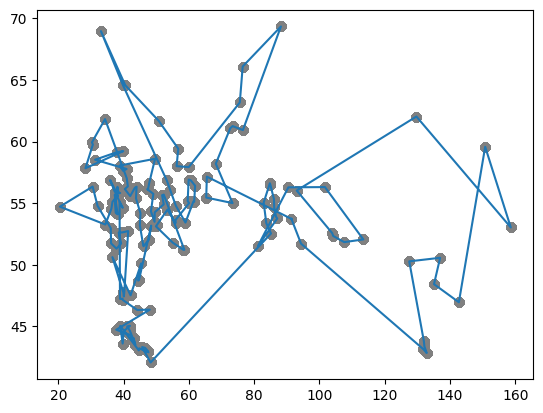

(True, 52382.9144688988)


In [436]:
res = [-1 for _ in range(n)]

solve(nodes[0], nodes[0], nodes, dists, res, 0)
plot_res(res)
print(valid(res, dists))

[54, 40, 96, 31, 123, 130, 151, 68, 28, 29, 126, 90, 135, 35, 33, 11, 41, 3, 102, 161, 65, 107, 45, 16, 8, 39, 7, 164, 128, 120, 42, 144, 154, 74, 75, 44, 79, 155, 24, 83, 58, 48, 63, 163, 133, 111, 121, 148, 162, 20, 69, 32, 150, 64, 1, 49, 129, 0, 109, 160, 165, 106, 118, 38, 5, 166, 60, 34, 52, 43, 77, 6, 149, 30, 70, 132, 22, 2, 93, 104, 26, 27, 17, 19, 112, 138, 15, 114, 13, 84, 139, 101, 82, 92, 122, 94, 143, 137, 81, 100, 91, 62, 56, 119, 14, 159, 57, 116, 95, 86, 147, 72, 12, 97, 46, 158, 47, 99, 85, 9, 37, 141, 140, 67, 113, 89, 50, 18, 88, 156, 76, 117, 78, 4, 145, 53, 103, 142, 134, 124, 87, 115, 55, 131, 23, 25, 157, 127, 110, 73, 98, 146, 125, 152, 21, 153, 59, 61, 51, 36, 136, 80, 71, 66, 10, 108, 105]


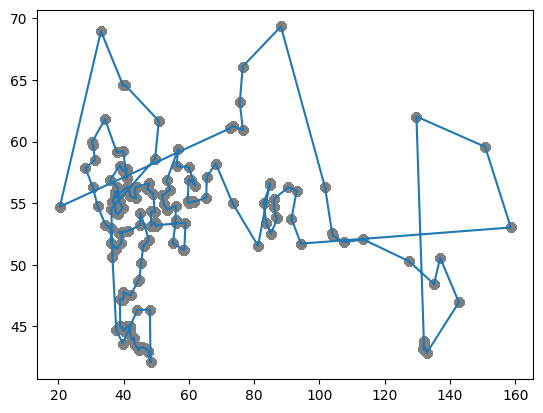

(True, 42334.16465744784)


In [441]:
def min_solve():
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = 0
    tsp = [-1 for _ in range(len(CITIES))]
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        visited[city] = True
        tsp[city] = closest
        city = closest
    return tsp

res = min_solve()
print(res)
plot_res(res)
print(valid(res, dists))

In [438]:
def to_list(res):
    k = 0
    init = k
    l = []
    while True:
        l +=[k]
        k = res[k]
        if(k == init):
            break

    return l

def improve(res):
    (_, min_cost) = valid(res, dists)
    num = len(CITIES)
    for k in range(num + nMs):
        impr = res.copy()
        l = to_list(impr)
        l = l+l
        (seq, _) = _solve(l[k], l[k+nMs+1], l[k+1: k+nMs+1], dists)
        seq = np.array(seq)
        save_res(seq, impr)
        (_, cost) = valid(impr, dists)
        if(cost < min_cost):
            res = impr
    return res

        

In [439]:
#res = improve(res)
#plot_res(res)
#print(valid(res, dists))

## EA

In [440]:
from tqdm.auto import tqdm

class tsp:
    def __init__(self, l):
        self.l = l
        self.n = len(self.l)
        self.crossType = None

    def getIndex(self, k):
        n = self.n
        if k >= 0:
            return k%n
        else:
            return (n-((-k)%n))%n
    
    def getl(self, k):
        return self.l[self.getIndex(k)]
    
    def setl(self, k, val):
        self.l[self.getIndex(k)] = val

    def copy(self):
        return tsp(self.l.copy())
    
class crossoverChooser:
    def __init__(self):
        self.crossoverList = []
        self.totList = None
        self.scoreList = None
        self.probList = None
    
    def add(self, crossover):
        self.crossoverList += [crossover]

    def next(self,):
        n = len(self.crossoverList)
        p = 0.5

        self.totList = [ 1 for _ in range(n)]
        self.scoreList = [ 1 for _ in range(n)]

        if self.probList is None:
            self.probList = [1/n for _ in range(n)]
        else:

            rapp = np.array([self.scoreList[k]/self.totList[k] for k in range(n)])
            sum = rapp.sum()
            self.probList = [ p/n + (1-p) * (r/sum) for r in rapp]
    
    def choose(self):
        i = np.random.choice(range(len(self.crossoverList)), size=None, p = self.probList)
        self.totList[i] += 1
        return (self.crossoverList[i], i)

    def register(self, type):
        self.scoreList[type] += 1

def cost(g):
    c = 0
    for i in range(len(g)-1):
        c += dists[g[i], g[i+1]]
        
    c+= dists[g[-1], g[0]]
    return c

def inver_over(p1, p2):
    i1 = np.random.randint(0, p1.n)
    g1 = p1.getl(i1)
    
    i2 = 0
    while p2.l[i2] != g1:
        i2 += 1
    
    g2 = p2.getl(i2+1)

    i12 = i1+1
    els = []
    while True:
        e = p1.getl(i12)
        if(e == g2):
            break
        els += [e]
        i12 += 1

    p_new = p1.copy()
    for j in range(len(els)):
        p_new.setl(i12-j, els[-j])
    
    p_new.setl(i1+1, g2)
    
    return p_new

def cycle(p1, p2):
    i1 = np.random.randint(0, p1.n)
    segment = set()

    end1 = None
    l = np.random.randint(0, 20)
    for k in range(l):
        end1 = p1.getl(i1+k)
        segment.add(end1)

    i1 += l

    i2 = 0
    while p2.l[i2] != end1:
        i2 += 1

    i2+=1

    p_new = p1.copy()

    c = 0
    for k in range(p2.n):
        e = p2.getl(i2+k)
        if e not in segment:
            p_new.setl(i1+c, e)
            c += 1
    
    return p_new


    

chooser = crossoverChooser()
chooser.add(inver_over)

def mate(pop, c):
    n = len(pop)

    new_pop = []
    for k in range(c * n):
        p1 = pop[np.random.randint(0, n)]
        p2 = pop[np.random.randint(0, n)]

        (crossover, t) = chooser.choose()
        c = crossover(p1, p2)
        c.crossType = t

        new_pop += [c]
    
    return new_pop

def mutate(pop):
    n = len(pop)
    for k in range(n):
        if(np.random.random() < 0.1):
            i1 = np.random.randint(0, len(pop[k].l))
            i2 = i1 + np.random.randint(0, 5)
            t = pop[k].getl(i1)
            pop[k].setl(i1, pop[k].getl(i2))
            pop[k].setl(i2, t)



nit = 1000
pop = [tsp(to_list(res)) for _ in range(100)]
n = len(pop)
best = None
min_cost = np.inf

for _ in tqdm(range(nit)):

    chooser.next()

    new_pop = mate(pop, 3)
    mutate(new_pop)
    
    #select
    scores = np.array([cost(g.l) for g in new_pop])
    sort_idxs = np.array(np.argsort(scores))

    #print(scores[sort_idxs])

    if scores[sort_idxs[0]] < min_cost:
        min_cost =  scores[sort_idxs[0]]
        best = new_pop[sort_idxs[0]].copy()
    
    for k in range(n):
        new_g = new_pop[sort_idxs[k]]
        pop[k] = new_g
        chooser.register(new_g.crossType)

print(cost(to_list(res)))
print(valid(res, dists))
print(min_cost)


100%|██████████| 1000/1000 [00:12<00:00, 77.20it/s]

42334.16465744784
(True, 42334.16465744784)
38418.80118833701
